<a href="https://colab.research.google.com/github/Somu-Gen/WQI_Streamlit/blob/main/Time_Series_Forecasting_Regression_and_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('/content/revised_vellore with dates.csv', encoding= 'unicode_escape',index_col=0)

In [ ]:
df.head()

,vellore,Latitude,Longitude,Date,TDS,Nitrates,Ca,Mg,Na,K,Cl,SO4,F,pH,wqi,quality
ï»¿,,,,,,,,,,,,,,,,
0,NaN,"12Â°56'40""","78Â°52'10""",01-01-2010,384.519457,13.176923,52.000000,37.0,143.000000,5.964226,170.000000,121.005792,0.626931,8.0,62.016553,Poor
1,NaN,"12Â°58'05""","79Â°12'25""",02-01-2010,384.519457,13.176923,58.751131,78.0,186.750398,5.964226,189.032909,121.005792,0.626931,7.4,60.684614,Poor
2,NaN,"13Â°06'17""","79Â°29'45""",03-01-2010,384.519457,13.176923,184.000000,73.0,239.000000,5.964226,189.032909,121.005792,0.626931,7.4,62.258597,Poor
3,NaN,"12Â°53'20""","78Â°46'00""",04-01-2010,384.519457,13.176923,58.000000,21.0,60.000000,5.964226,39.000000,121.005792,0.626931,8.1,61.555553,Poor
4,NaN,"12Â°59'45""","78Â°54'40""",05-01-2010,384.519457,13.176923,40.000000,38.0,115.000000,5.964226,46.000000,121.005792,0.626931,8.0,61.693762,Poor


In [ ]:
df1=df[df['wqi']<=80]
df1=df1[df1['wqi']>=40 ]

In [ ]:
df.shape,df1.shape

((3957, 16), (2678, 16))

In [ ]:
time = pd.to_datetime(df.Date, dayfirst=True)
series = df['wqi'][5::6]
series.index = time[5::6]

In [ ]:
time

ï»¿
0      2010-01-01
1      2010-01-02
2      2010-01-03
3      2010-01-04
4      2010-01-05
          ...    
3952   2020-10-27
3953   2020-10-28
3954   2020-10-29
3955   2020-10-30
3956   2020-10-31
Name: Date, Length: 3957, dtype: datetime64[ns]

In [ ]:
import numpy as np

# function for generating the lagged matrix
def split_sequence(sequence, window_size):
    X = []
    y = []
    # for all indexes
    for i in range(len(sequence)):
        end_idx = i + window_size
        # exit condition
        if end_idx > len(sequence) - 1:
            break
        # get X and Y values
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


#train = series[:-int(len(series)/10)]
test = series[-int(len(series)/10):]
train=series

X_train, y_train = split_sequence(train, window_size=24)
X_test, y_test = split_sequence(test, window_size=24)

In [ ]:
import statsmodels.api as sm

# train Ordinary Least Squares model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()

print(result.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.650
Date:                Sat, 23 Apr 2022   Prob (F-statistic):           3.83e-05
Time:                        10:10:50   Log-Likelihood:                -2912.2
No. Observations:                 635   AIC:                             5874.
Df Residuals:                     610   BIC:                             5986.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.1680     10.179      5.125      0.0

In [ ]:
from scipy import stats

# get values of the residuals
residual = result.resid

# run tests and get the p values
print('p value of Jarque-Bera test is: ', stats.jarque_bera(residual)[1])
print('p value of Shapiro-Wilk test is: ', stats.shapiro(residual)[1])
print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(residual, 'norm')[1])

p value of Jarque-Bera test is:  0.0
p value of Shapiro-Wilk test is:  2.4059745873631787e-16
p value of Kolmogorov-Smirnov test is:  3.8135887594362627e-109


In [ ]:
import statsmodels.stats.api as sms

print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(result.resid, result.model.exog)[1])
print('p value of White test is: ', sms.het_white(result.resid, result.model.exog)[1])

p value of Breusch–Pagan test is:  0.35056299591989637
p value of White test is:  2.706811644005601e-13


In [ ]:
import statsmodels.api as sm

# train Ordinary Least Squares model
X_train = sm.add_constant(X_train)
model = sm.GLS(y_train, X_train)
result = model.fit()

print(result.summary())

In [ ]:
X_test, y_test = split_sequence(test, window_size=24)

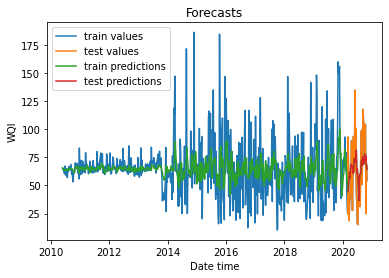

In [ ]:
X_test = sm.add_constant(X_test)

y_train_preds = result.predict(X_train)
y_test_preds = result.predict(X_test)

from matplotlib import pyplot as plt

# indexes start from 24 due to the window size we chose
plt.plot(pd.Series(y_train, index=train[24:].index), label='train values')
plt.plot(pd.Series(y_test, index=test[24:].index), label='test values')
plt.plot(pd.Series(y_train_preds, index=train[24:].index), label='train predictions')
plt.plot(pd.Series(y_test_preds, index=test[24:].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('WQI')
plt.title('Forecasts')
plt.legend()
plt.show()

In [ ]:
#pd.Series(y_test_preds).plot()
X_test

array([[  1.        ,  34.63765092,  75.26935025, ...,  79.19452854,
         47.85646298,  29.96139293],
       [  1.        ,  75.26935025,  76.85606156, ...,  47.85646298,
         29.96139293,  24.97232072],
       [  1.        ,  76.85606156, 104.3458151 , ...,  29.96139293,
         24.97232072,  92.95357661],
       ...,
       [  1.        ,  62.22848656, 134.588141  , ...,  76.58466789,
        100.8135655 , 104.0756171 ],
       [  1.        , 134.588141  ,  66.76816087, ..., 100.8135655 ,
        104.0756171 ,  24.92895639],
       [  1.        ,  66.76816087, 100.7431074 , ..., 104.0756171 ,
         24.92895639,  68.90764187]])

#RNN

In [ ]:
import pandas as pd
df = pd.read_csv('/content/revised_vellore with dates.csv', encoding= 'unicode_escape',index_col=0)
time = pd.to_datetime(df.Date, dayfirst=True)
series = df['wqi'][5::6]
series.index = time[5::6]

In [ ]:
# train test split
train1 = series
train=series[:-int(len(series)/10)]
train_idx = train.index
train1_idx=train1.index
test = series[-int(len(series)/10):]
test_idx = test.index

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = pd.Series(scaler.fit_transform(train.values.reshape(-1, 1))[:, 0], index=train_idx)
train1=pd.Series(scaler.fit_transform(train1.values.reshape(-1, 1))[:, 0], index=train1_idx)
test = pd.Series(scaler.transform(test.values.reshape(-1, 1))[:, 0], index=test_idx)

In [ ]:
window_size = 24

X_train, y_train = split_sequence(train, window_size=window_size)
X_train1, y_train1 = split_sequence(train1, window_size=window_size)
X_test, y_test = split_sequence(test, window_size=window_size)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# convert train and test data to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# use torch tensor datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# get data loaders
batch_size = 32
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [ ]:
from torch import nn


class DenseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers=1, bidirectional=False, dense=False):
        super(DenseLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layers = lstm_layers
        self.bidirectional = bidirectional
        self.dense = dense
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size=self.input_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.layers,
                            bidirectional=self.bidirectional)
        self.act1 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional
        if not bidirectional:
            self.linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        else:
            self.linear = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.act2 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional and extra dense layer isn't added
        if bidirectional and not dense:
            self.final = nn.Linear(self.hidden_dim * 2, 1)
        else:
            self.final = nn.Linear(self.hidden_dim, 1)


    def forward(self, inputs, labels=None):
        out = inputs.unsqueeze(1)
        out, h = self.lstm(out)
        out = self.act1(out)
        if self.dense:
            out = self.linear(out)
            out = self.act2(out)
        out = self.final(out)
        return out



training function

In [ ]:
import time

def fit(model, optimizer, criterion):
    print("{:<8} {:<25} {:<25} {:<25}".format('Epoch', 
                                          'Train Loss', 
                                          'Test Loss', 
                                          'Time (seconds)'))
    for epoch in range(epochs):
        model.train()
        start = time.time()
        epoch_loss = []
        # for batch in train data
        for step, batch in enumerate(train_dataloader):
            # make gradient zero to avoid accumulation
            model.zero_grad()
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            out.to(device)
            # get loss
            loss = criterion(out, labels)
            epoch_loss.append(loss.float().detach().cpu().numpy().mean())
            # backpropagate
            loss.backward()
            optimizer.step()
        test_epoch_loss = []
        end = time.time()
        model.eval()
        # for batch in validation data
        for step, batch in enumerate(test_dataloader):
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            # get loss
            loss = criterion(out, labels)     
            test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        print("{:<8} {:<25} {:<25} {:<25}".format(epoch+1, 
                                                  np.mean(epoch_loss), 
                                                  np.mean(test_epoch_loss), 
                                                  end-start))




Now we can begin the training. We define the hidden layer sizes, epochs, loss function, and which optimizer we will use. Then we train the model and plot the predictions

Epoch    Train Loss                Test Loss                 Time (seconds)           
1        1.046974539756775         1.8082035779953003        0.18414592742919922      


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(in

2        1.0376765727996826        1.7797622680664062        0.07451343536376953      
3        1.0384173393249512        1.7676736116409302        0.08008170127868652      
4        1.045141339302063         1.771907925605774         0.06881976127624512      
5        1.0388882160186768        1.7734795808792114        0.07129955291748047      
6        1.068184494972229         1.7705328464508057        0.07453656196594238      
7        1.0422186851501465        1.7520087957382202        0.06786417961120605      
8        1.0374045372009277        1.7515161037445068        0.07600545883178711      
9        1.0393301248550415        1.750108003616333         0.06799674034118652      
10       1.0344767570495605        1.7575359344482422        0.07505440711975098      


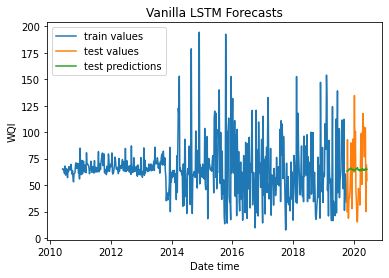

In [ ]:
device = torch.device(type='cuda')

hidden_dim = 32
epochs = 10

# vanilla LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=1, bidirectional=False, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('WQI')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()


Stacked LSTM

In [ ]:
device = torch.device(type='cuda')

hidden_dim = 32
epochs = 5

# Stacked LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=False, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train1.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('WQI')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()

In [ ]:
device = torch.device(type='cpu')

hidden_dim = 32
epochs = 5

# Biderctional LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train1.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('WQI')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()

In [ ]:
device = torch.device(type='cpu')

hidden_dim = 32
epochs = 50

# Stacked Bidirectional LSTMs with a fully-connected layers
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=True)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train1.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('WQI')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()